# COS-method

We offer you the following practical task on the COS-method. 

Total score is **110**, which will be converted to $22\%$ of the course grade. You have $1$ month for this work. **Deadline is the 30st of December, 23:59 MSK**.

The file must be sent to **stoch-vol-23-fall@yandex.ru** with topic "stoch-vol Lab2".  Please rename your file as **"SurnameName_Lab2.ipynb"** before sending. 

If you have any questions feel free to ask in Telegram in the **group chat**.

<u>Full name</u>: **Safonova Elizaveta**

<u>Faculty</u>: ***Faculty of computational mathematics and cybernetics (CMC MSU)***

In [1]:
from copy import deepcopy
from typing import Callable, Union
import math
from dataclasses import dataclass, replace, is_dataclass

import numpy as np
import matplotlib 
import numpy.typing as npt
from scipy import stats as st
import matplotlib.pyplot as plt
from tqdm.auto import tqdm, trange
from math import *
from py_vollib.black_scholes.implied_volatility import implied_volatility
plt.style.use('https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pitayasmoothie-light.mplstyle')

C:\Users\Elis\anaconda3\envs\myenv\lib\site-packages\py_lets_be_rational\numba_helper.py:10: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  return jit(*jit_args, **jit_kwargs)(fun)


In [2]:
font = {'family':'Times New Roman', 'size': 10}
matplotlib.rc('font', **font)

In [3]:
implied_volatility_vec = np.vectorize(implied_volatility)

# Episode 1: pricing with COS-method (50 points)

In [4]:
FloatArray = npt.NDArray[np.float_]
Floats = Union[float, FloatArray]

@dataclass
class MarketState:
    stock_price: Floats
    interest_rate: Floats
    time: Floats = 0

@dataclass
class HestonParams:
    v: float # initial variance V_0
    kappa: float # speed of mean-reversion 
    theta: float # long-term mean
    sigma: float # vol of vol
    rho: float # correlation between brownian motions
    
@dataclass
class StockOption:
    strike_price: Floats
    expiration_time: Floats  # in years
    is_call: Union[bool, npt.NDArray[np.bool_]] = None
    
    def __post_init__(self):
        assert self.is_call is not None
    
    def payoff(self, stock_price: Floats) -> Floats:
        call_payoff = np.maximum(0, stock_price - self.strike_price)
        put_payoff = np.maximum(0, self.strike_price - stock_price)
        return np.where(self.is_call, call_payoff, put_payoff)

class CallStockOption(StockOption):
    def __post_init__(self):
        self.is_call = True
        
class PutStockOption(StockOption):
    def __post_init__(self):
        self.is_call = False

In [5]:
def heston_log_char_func(omega: Floats,
                         dt: Floats,
                         p: HestonParams) -> Floats:
    """Computes the logarithm og the Heston characteristic function assuming the stock
    trades at 1 and no drift.

    To recover the CF if the stock trades at s multiply by the factor
    exp(i omega (log(s) + \mu dt)) the exponent of the result.

    Args:
        omega: frequency dual to the price domain
        dt: time to evaluate CF at
        p: model parameters

    Returns:
        float: log characteristic function value
    """
    D = np.sqrt(
        (p.kappa - 1j * p.rho * p.sigma * omega) ** 2
        + (omega ** 2 + 1j * omega) * p.sigma ** 2
    )
    F = p.kappa - 1j * p.rho * p.sigma * omega - D
    G = F / (F + 2 * D)
    df = np.exp(-D * dt)  # discount factor
    return (
        p.v / p.sigma ** 2 * (1 - df) / (1 - G * df) * F
        + p.kappa * p.theta / p.sigma ** 2 * (
            dt * F - 2 * np.log((1 - G * df) / (1 - G))
        )
    )

## Implement coefficients for vanilla put

$$
\chi_k(c, d)= \frac{1}{1+\left(\frac{k \pi}{b-a}\right)^2}\left[\cos \left(k \pi \frac{d-a}{b-a}\right) e^d-\cos \left(k \pi \frac{c-a}{b-a}\right) e^c+\frac{k \pi}{b-a} \sin \left(k \pi \frac{d-a}{b-a}\right) e^d-\frac{k \pi}{b-a} \sin \left(k \pi \frac{c-a}{b-a}\right) e^c\right]
$$

$$
\psi_k(c, d):= \begin{cases}{\left[\sin \left(k \pi \frac{d-a}{b-a}\right)-\sin \left(k \pi \frac{c-a}{b-a}\right)\right] \frac{b-a}{k \pi}}, & k \neq 0, \\ (d-c), & k=0 .\end{cases}
$$

$$
V_k^{\text {call }}=\frac{2}{b-a} \int_0^b K\left(e^y-1\right) \cos \left(k \pi \frac{y-a}{b-a}\right) d y=\frac{2}{b-a} K\left(\chi_k(0, b)-\psi_k(0, b)\right),
$$

$$
V_k^{p u t}=\frac{2}{b-a} K\left(-\chi_k(a, 0)+\psi_k(a, 0)\right) .
$$

In [6]:
def vanilla_put_cos_expansion_coeffs(a: Floats,
                                     b: Floats,
                                     k: int) -> Floats:
    """
    Computes the cosine expansion coefficients of the vanilla put option
    payoff.

    Args:
        a, b: integration bounds for the payoff function
        k: number of coefficients

    Returns:
        vector of coefficients
    """
    assert np.shape(a) == np.shape(b)
    def chi(c: Floats, d: Floats, i: int) -> Floats:
        
        coeff = i * pi / (b - a)
        f1 = lambda x: np.cos(coeff * (x - a)) * np.exp(x)
        f2 = lambda x: np.sin(coeff * (x - a)) * np.exp(x)
        
        return (1 / (1 + coeff**2)) * (f1(d) - f1(c) + coeff * f2(d) - coeff * f2(c))
        
    def psi(c: Floats, d: Floats, i: int) -> Floats:
        
        coeff = i * pi / (b - a)
        f = lambda x: np.sin(coeff * (x - a))
        if i != 0:
            return (f(d) - f(c)) * 1 / coeff
        else:
            return d - c
        
    res = np.zeros((*np.shape(a), k))  
    for index in range(k):
        res.T[:][index] = 2 / (b - a) * (-chi(a, 0, index) + psi(a, 0, index))
    #print(res)    
    return res

## Implement the COS method

For now use the following stub to calculate the truncation range

$$
P\approx e^{-rT} 
\left(\frac{V_0}{2} 
  + \sum_{n=1}^N \mathrm{Re}\left\{ 
    \phi_T\left(\frac{n\pi}{b-a}\right)e^{-in\pi \frac{x(K) - a}{b-a}} 
  \right\} V_n 
\right),\; x(K) = \log \left(S_0 / K\right)
$$

$V_n$ can be found analytically for some payoffs.

In [7]:
def calc_trunc_range(eps: float, params: HestonParams, dt: float):
    return np.array(300.)

In [8]:
def price(
    option: StockOption,
    ms: MarketState,
    params: HestonParams,
    eps: float = 1e-3,
    n_points: int = 4096,
):
    dt = np.asarray(option.expiration_time - ms.time)
    res_trunc_range = calc_trunc_range(eps, params, dt)
    a = - res_trunc_range / 2
    b = res_trunc_range / 2
    
    K = option.strike_price
    
    V_k =  vanilla_put_cos_expansion_coeffs(a, b, n_points).reshape(n_points, 1) * K.reshape(1, len(K))
    V_0 = np.array([0.5]*len(K))
    
    x_K = np.log(ms.stock_price/K/np.exp(-ms.interest_rate * dt))
    
    #x_K = np.log(ms.stock_price / K)
    x_K[x_K < a] = a
    x_K[x_K > b] = b
    
    w = pi * np.arange(n_points) / (b - a)
    
    tmp = np.exp(heston_log_char_func(w, dt, params)).reshape(n_points, 1)
    tmp2 =  np.exp((1j * np.arange(n_points) * pi).reshape(n_points, 1) * ((x_K - a) / (b - a)).reshape(1, len(x_K)))
    coeff = np.real(tmp * tmp2)
    coeff[0] = V_0
    
    put_price = np.sum(V_k * coeff, axis=0) * np.exp(- ms.interest_rate * dt)
        
    if option.is_call:
        return put_price + ms.stock_price - np.exp(-ms.interest_rate * dt) * K #put-call parity
    else:
        return put_price

In [9]:
strikes = np.linspace(40, 200, 15)

time = np.array(1.0)

calls = CallStockOption(strike_price=strikes,
                        expiration_time=time)
puts = PutStockOption(strike_price=strikes,
                      expiration_time=time)

ms = MarketState(stock_price=100, interest_rate=0.05)

params = HestonParams(v=0.1, kappa=2, theta=0.1, sigma=0.7, rho=-0.2)

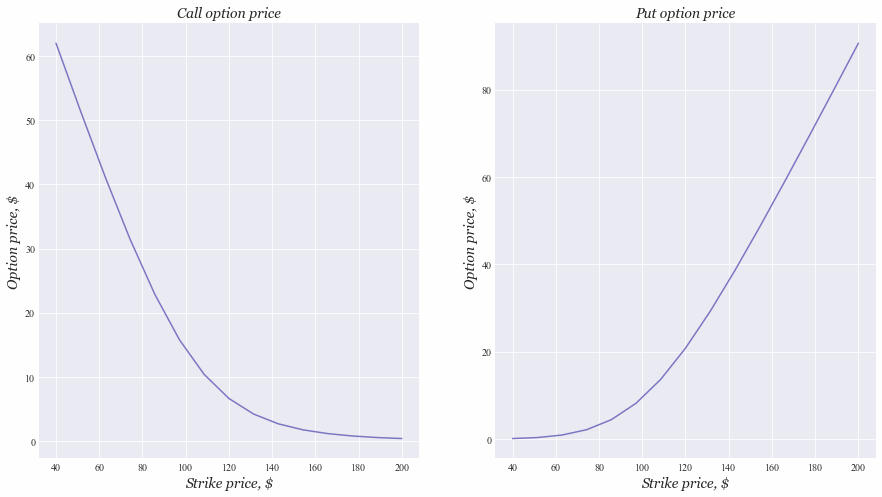

In [10]:
call_price = price(calls, ms, params)
put_price = price(puts, ms, params)

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15, 8))

ax1.plot(strikes, call_price)
ax1.set_title('Call option price', fontname = "Georgia", style="italic", fontsize = 14)
ax1.set_xlabel('Strike price, $', fontname = "Georgia", style="italic", fontsize = 14)
ax1.set_ylabel('Option price, $', fontname = "Georgia", style="italic", fontsize = 14)

ax2.plot(strikes, put_price)
ax2.set_title('Put option price', fontname = "Georgia", style="italic", fontsize = 14)
ax2.set_xlabel('Strike price, $', fontname = "Georgia", style="italic", fontsize = 14)
ax2.set_ylabel('Option price, $', fontname = "Georgia", style="italic", fontsize = 14)

plt.show()

# Episode 2: checking with MC (30 points)

implement the `price_mc` function and check the correctness of the imlementation.

In [11]:
class BaseHestonSimulState:
    def __init__(
        self,
        params: HestonParams,
        ms: MarketState,
        shape: Union[int, tuple[int]],
    ):
        raise NotImplemented

    @property
    def stock_price(self) -> Floats:
        raise NotImplemented
        
    def advance(
        self,
        dt: float,
        random: np.random.Generator,
    ):
        raise NotImplemented

def simulate_heston(
    params: HestonParams,
    initial_simul_state: BaseHestonSimulState,
    time_stop: float = 1.0,
    n_time_steps: int = 100,
    random_seed: int = 0x11A_3AB0D,
    ret_intermediate_states: bool = False,
):
    random = np.random.default_rng(random_seed)
    dt = (time_stop - ms.time) / n_time_steps
    hs = initial_simul_state
    
    if ret_intermediate_states:
        states = [deepcopy(hs)]
        
    stock_price = np.empty((*np.shape(initial_simul_state.stock_price), n_time_steps + 1))
    stock_price[:, 0] = initial_simul_state.stock_price
    
    for i in trange(n_time_steps):
        hs.advance(dt, random)
        stock_price[:, i + 1] = hs.stock_price
        
        if ret_intermediate_states:
            states.append(deepcopy(hs))
    
    if ret_intermediate_states:
        return stock_price, states
    
    return stock_price

In [12]:
@dataclass
class LogEulerSimulState(BaseHestonSimulState):
    def __init__(
        self,
        params: HestonParams,
        ms: MarketState,
        shape: Union[int, tuple[int]],
    ):
        self._log_stock_price = np.full(shape, np.log(ms.stock_price))
        self._variance = np.full(shape, params.v)
        self._interest_rate = ms.interest_rate
        self._p = params
    
    @property
    def log_stock_price(self):
        return self._log_stock_price
    
    @property
    def stock_price(self):
        return np.exp(self._log_stock_price)
    
    @property
    def variance(self):
        return self._variance

    def advance(
        self,
        dt: float,
        random: np.random.Generator,
    ):
        z1, z2 = random.normal(size=(2, *np.shape(self._log_stock_price)))
        dW_v = z1 * math.sqrt(dt)
        dW_s = math.sqrt(dt) * (self._p.rho * z1 + math.sqrt(1 - self._p.rho**2) * z2)
        new_v = (
            self._variance
            + self._p.kappa * (self._p.theta - self._variance) * dt
            + self._p.sigma * np.sqrt(self._variance) * dW_v
        )
        new_log_s = (
            self._log_stock_price
            + (self._interest_rate - self._variance / 2) * dt
            + np.sqrt(self._variance) * dW_s
        )
        self._log_stock_price = new_log_s
        # self.variance = np.maximum(new_v, 0)
        self._variance = np.where(
            new_v > 0,
            new_v,
            new_v - 2 * self._p.sigma * np.sqrt(self._variance) * dW_v
        )

In [13]:
N_PATHS = 10
N_STEPS = 100
T = 1.0

params = HestonParams(v=0.1, kappa=2, theta=0.1, sigma=0.7, rho=-0.2)
ms = MarketState(stock_price=100.0, interest_rate=0.0, time=0)

In [14]:
hs = LogEulerSimulState(params, ms, N_PATHS)
paths, states = simulate_heston(
    # params,
    replace(params, theta=20.0),
    hs,
    time_stop=T,
    n_time_steps=N_STEPS,
    ret_intermediate_states=True,
)

  0%|          | 0/100 [00:00<?, ?it/s]

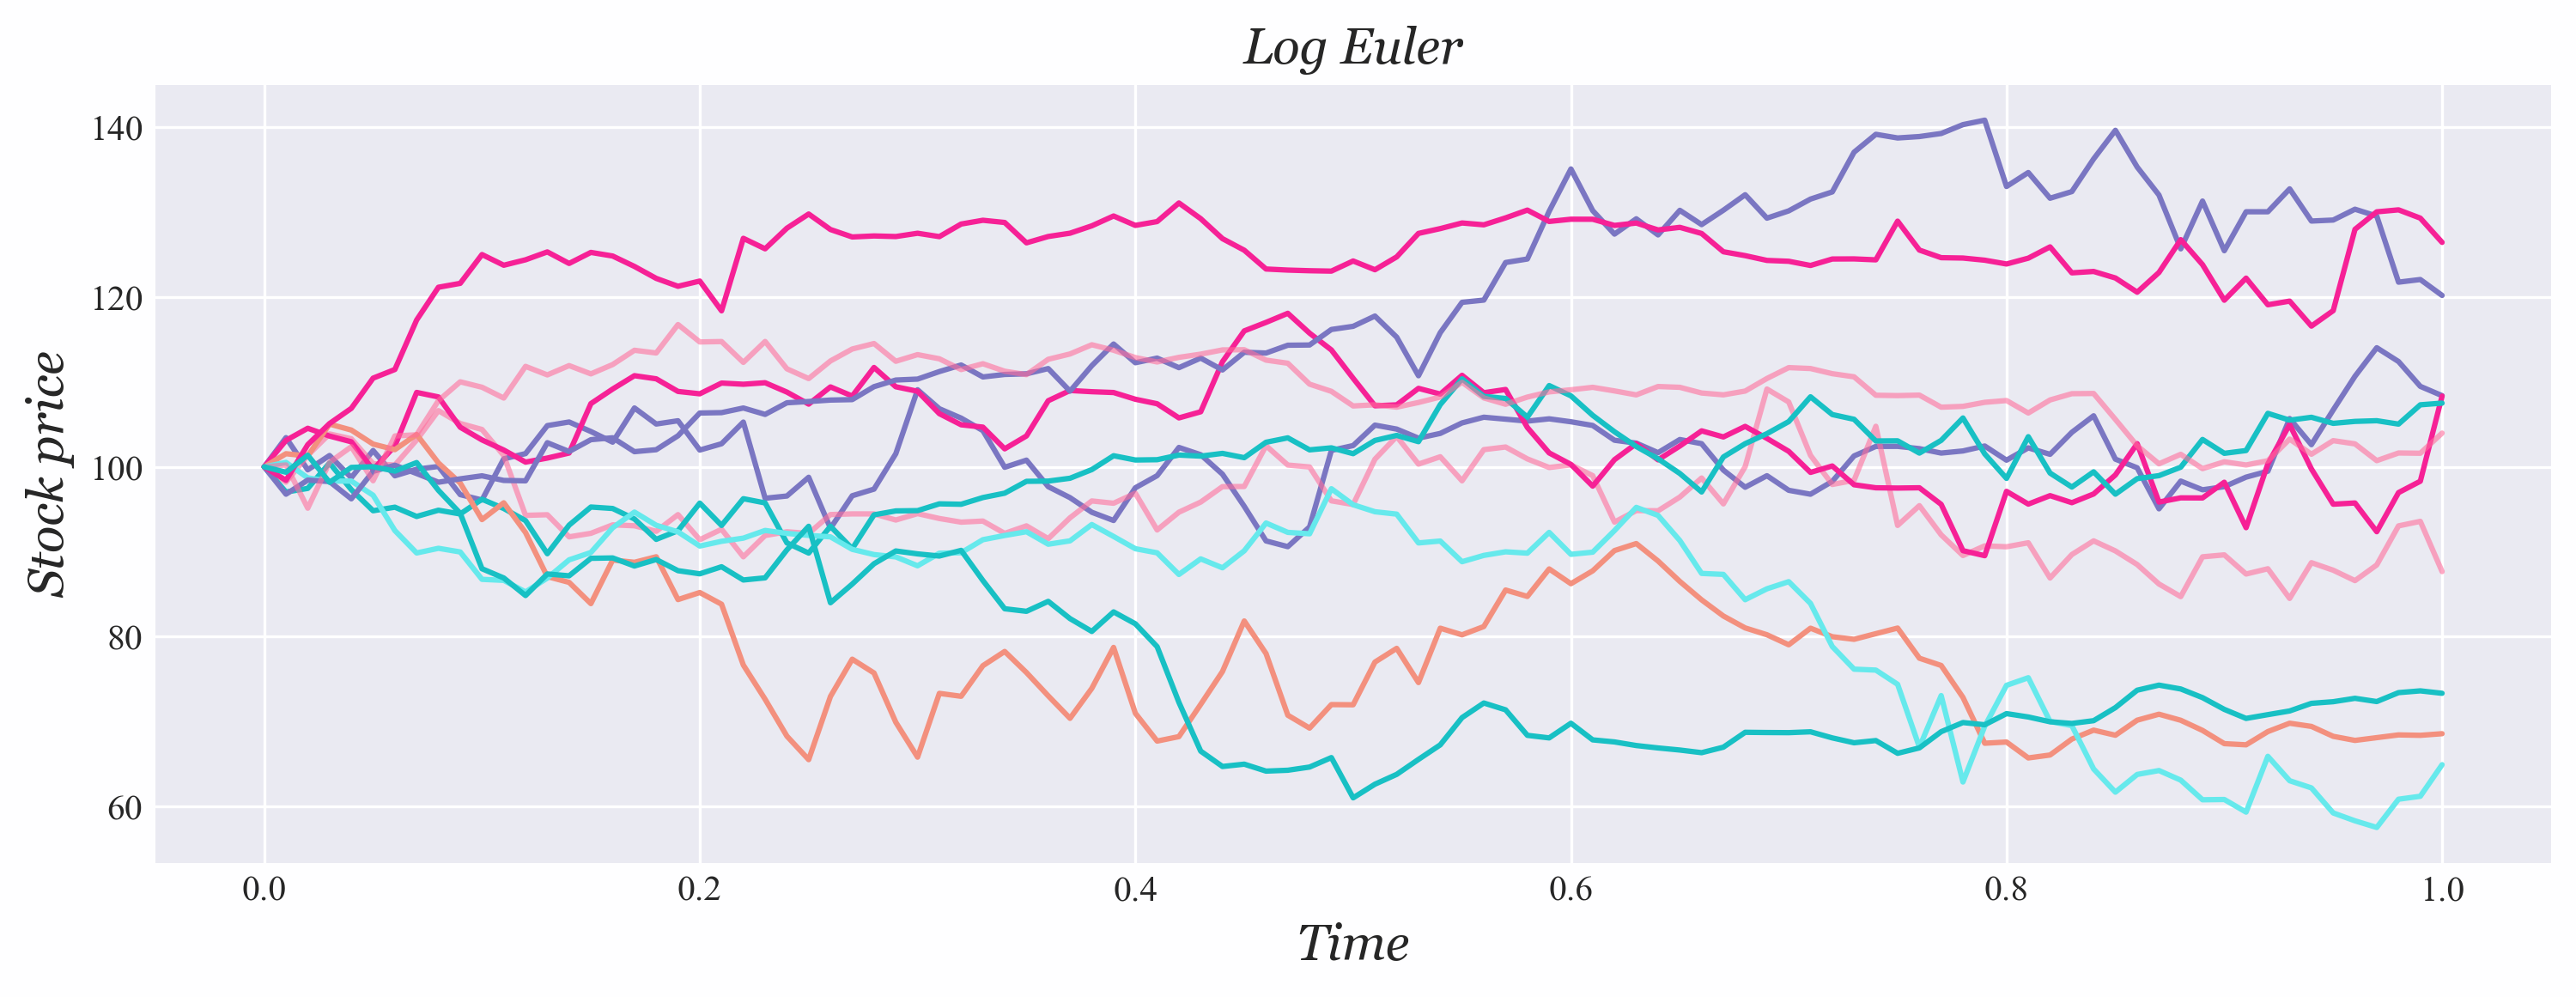

In [15]:
_, ax = plt.subplots(figsize=(12, 4), dpi=300)
ax.plot(np.linspace(ms.time, T, N_STEPS + 1), paths.T)
ax.set_title("Log Euler", fontname = "Georgia", style="italic", fontsize = 14)
ax.set_xlabel("Time", fontname = "Georgia", style="italic", fontsize = 14)
ax.set_ylabel("Stock price", fontname = "Georgia", style="italic", fontsize = 14)
plt.show()

In [16]:
n_paths = 10000

In [17]:
def price_mc(
    option: StockOption,
    ms: MarketState,
    params: HestonParams,
    n_points: int,
):
    hs = LogEulerSimulState(params, ms, n_paths)
    paths = simulate_heston(
        # params,
        replace(params, theta=20.0),
        hs,
        time_stop=option.expiration_time,
        n_time_steps=n_points,
        ret_intermediate_states=False,
    )
    K = option.strike_price
    arr = paths[:, -1].reshape(n_paths, 1) - K.reshape(1, len(K))  
    res = np.exp(-ms.interest_rate * (option.expiration_time-ms.time)) * np.mean(np.maximum((-1 + 2 * option.is_call) * arr, 0), axis=0)
    return res

In [18]:
strikes = np.linspace(70, 140, 16)
time = np.array(1.0)

calls = CallStockOption(strike_price=strikes,
                        expiration_time=time)
puts = PutStockOption(strike_price=strikes,
                      expiration_time=time)

ms = MarketState(stock_price=100, interest_rate=0.1)

params = HestonParams(v=0.1, kappa=2, theta=0.1, sigma=0.7, rho=-0.2)

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

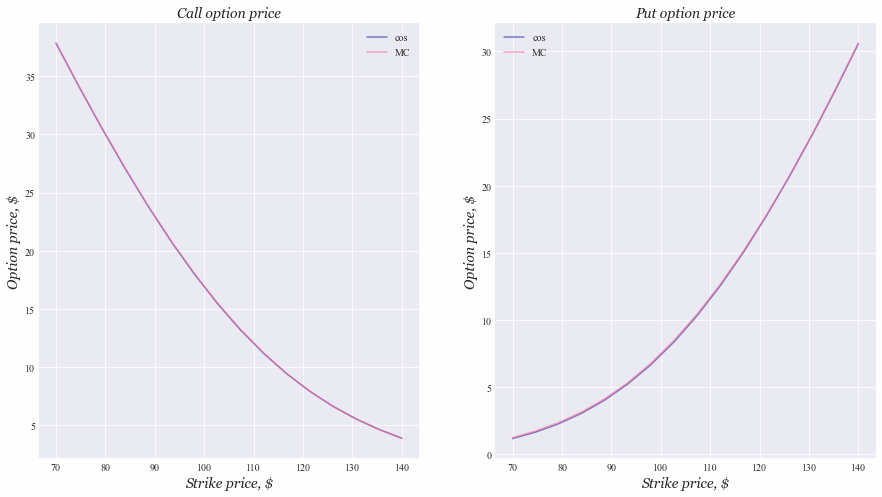

In [19]:
call_price_mc = price_mc(calls, ms, params, 100000)
put_price_mc = price_mc(puts, ms, params, 100000)
call_price = price(calls, ms, params)
put_price = price(puts, ms, params)

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15, 8))

ax1.plot(strikes, call_price, label="cos")
ax1.plot(strikes, call_price_mc, label="MC")
ax1.set_title('Call option price', fontname = "Georgia", style="italic", fontsize = 14)
ax1.set_xlabel('Strike price, $', fontname = "Georgia", style="italic", fontsize = 14)
ax1.set_ylabel('Option price, $', fontname = "Georgia", style="italic", fontsize = 14)
ax1.legend()

ax2.plot(strikes, put_price, label="cos")
ax2.plot(strikes, put_price_mc, label="MC")
ax2.set_title('Put option price', fontname = "Georgia", style="italic", fontsize = 14)
ax2.set_xlabel('Strike price, $', fontname = "Georgia", style="italic", fontsize = 14)
ax2.set_ylabel('Option price, $', fontname = "Georgia", style="italic", fontsize = 14)
ax2.legend()

plt.show()

In [20]:
def iv(option: StockOption, ms: MarketState, price: Floats):
    assert isinstance(option, (CallStockOption, PutStockOption))
    
    flag = "c" if isinstance(option, CallStockOption) else "p"
    return implied_volatility_vec(
        price=price,
        S=ms.stock_price,
        K=option.strike_price,
        t=option.expiration_time - ms.time,
        r=ms.interest_rate,
        flag=flag,
    )

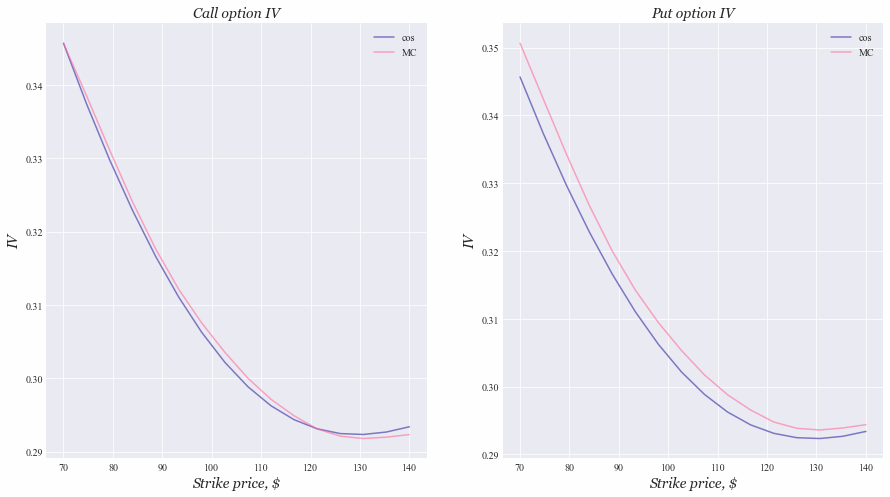

In [21]:
call_iv_mc = iv(calls, ms, call_price_mc)
put_iv_mc = iv(puts, ms, put_price_mc)
call_iv = iv(calls, ms, call_price)
put_iv = iv(puts, ms, put_price)

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15, 8))

ax1.plot(strikes, call_iv, label="cos")
ax1.plot(strikes, call_iv_mc, label="MC")
ax1.set_title('Call option IV', fontname = "Georgia", style="italic", fontsize = 14)
ax1.set_xlabel('Strike price, $', fontname = "Georgia", style="italic", fontsize = 14)
ax1.set_ylabel('IV', fontname = "Georgia", style="italic", fontsize = 14)
ax1.legend()

ax2.plot(strikes, put_iv, label="cos")
ax2.plot(strikes, put_iv_mc, label="MC")
ax2.set_title('Put option IV', fontname = "Georgia", style="italic", fontsize = 14)
ax2.set_xlabel('Strike price, $', fontname = "Georgia", style="italic", fontsize = 14)
ax2.set_ylabel('IV', fontname = "Georgia", style="italic", fontsize = 14)
ax2.legend()

plt.show()

# Episode 3: the truncatoin range (20 points)

Implement the truncation range choosing algorithm from one of the following papers:
1. [Original paper](https://mpra.ub.uni-muenchen.de/9319/1/MPRA_paper_9319.pdf)
1. [Markov's inequality based](https://www.sciencedirect.com/science/article/pii/S0096300322000212/pdfft?md5=b288c9e0da77d57a61e5a496dffde778&pid=1-s2.0-S0096300322000212-main.pdf)

Use whatever you want: analytical solution, automatic differentiation, automatic code generation, even rust.
Have fun!

In [22]:
# @partial (jax.jit, static_argnums=2, static_argnames="n") 
def _log_price_nth_moment (dt: Union [float, jnp.ndarray],
                           p: HestonParameters,
                           n: int) -> Union [float, jnp.ndarray]: 
    """Computes nth moment of the log-price in Heston model
    Args:
        dt: time point at which to compute the moment
        p (HestonParameters): Heston model parameters
        n (int): nth moment will be calculated
    Returns:
        float or jnp.ndarrat of shape equal to the dt's shape: nth moment of the logarithm of price"""
    
    if jnp.ndim(dt) > 0:
        shape = jnp.shape(dt)
        mapped = jax.vmap(_log_price_nth_moment, in_axes=(0, None, None))
        res_flat = mapped(jnp.asarray(dt).flatten(), p, n)
        return jnp.reshape(res_flat, shape)
    
    f = partial(heston_log_char_func, dt=dt, p=p)
    for _ in range(n):
        f = jax.grad(f, holomorphic=True)
    return jnp.real(f(jnp.array(0, dtype=jnp.complex_))/(1j**n))

NameError: name 'jnp' is not defined

# Episode 4: Memes (10 points) 🤡

Come up with a funny financial math meme.
If the meme is not funny, then we will have to deduct points.
Don't steal memes, come up with your own!

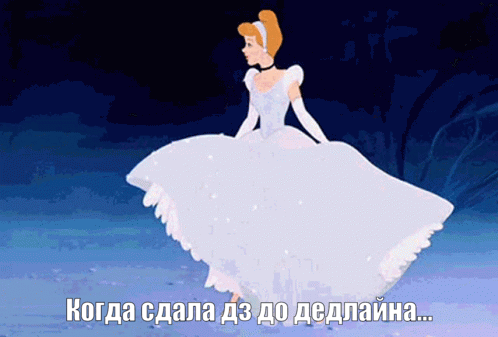

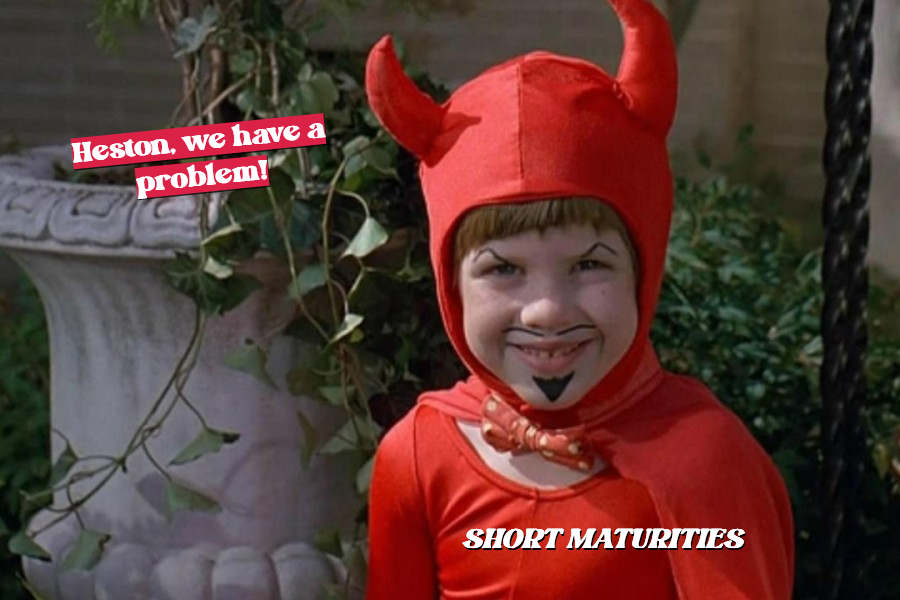